In [1]:
!ls ../data/*.csv

../data/gender_test_kaggle_sample_submission.csv  ../data/tr_mcc_codes.csv
../data/gender_train.csv			  ../data/tr_types.csv
../data/test_ids.csv				  ../data/transactions.csv


In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
df_trx = pd.read_csv("../data/transactions.csv")

In [6]:
df_trx['customer_id'] = df_trx['customer_id'].astype('str')
df_trx['mcc_code'] = df_trx['mcc_code'].astype('str')
df_trx['tr_type'] = df_trx['tr_type'].astype('str')
df_trx['term_id'] = df_trx['term_id'].astype('str')

In [7]:
df_trx['dt'] = df_trx['tr_datetime'].str.rjust(12, '0').str[:3].astype(int)

In [8]:
df_trx

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,dt
0,39026145,0 10:23:26,4814,1030,-2245.92,nan,0
1,39026145,1 10:19:29,6011,7010,56147.89,nan,1
2,39026145,1 10:20:56,4829,2330,-56147.89,nan,1
3,39026145,1 10:39:54,5499,1010,-1392.47,nan,1
4,39026145,2 15:33:42,5499,1010,-920.83,nan,2
...,...,...,...,...,...,...,...
6849341,61870738,453 16:03:02,5499,1010,-5176.84,10217113,453
6849342,61870738,454 10:54:60,5411,1010,-1652.77,022915,454
6849343,61870738,454 14:23:59,5499,1010,-4687.23,10217113,454
6849344,61870738,454 16:11:53,5541,1110,-4491.83,RU570124,454


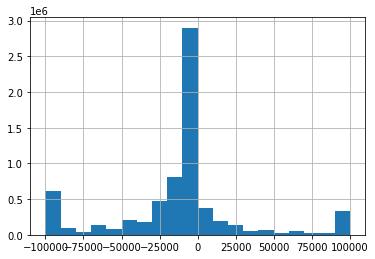

In [9]:
df_trx['amount'].clip(-100000, 100000).hist(bins=20)
plt.show()

In [10]:
df_trx['amount'] = -1 * df_trx['amount']

In [11]:
df_amounts_by_day = df_trx.groupby('dt')['amount'].sum()

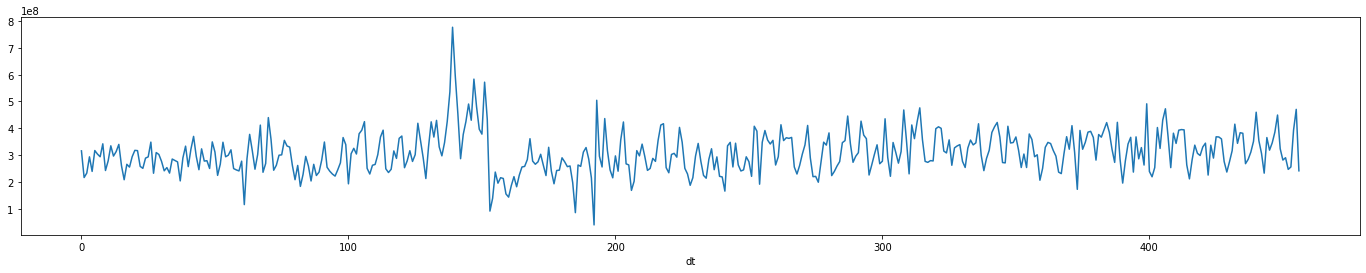

In [12]:
df_amounts_by_day.plot(figsize=(24, 4))
plt.show()

# Test periodicity

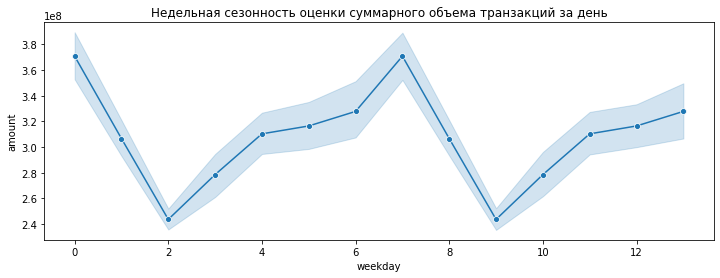

In [13]:
period = 7
ci = 95
_, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    data=pd.concat([
        df_amounts_by_day.reset_index().assign(weekday=lambda x: x['dt'] % period),
        df_amounts_by_day.reset_index().assign(weekday=lambda x: x['dt'] % period + 7),
    ], axis=0),
    x='weekday', y='amount',
    marker='o',
    ax=ax,
    ci=ci
)
ax.set_title('Недельная сезонность оценки суммарного объема транзакций за день')
plt.show()

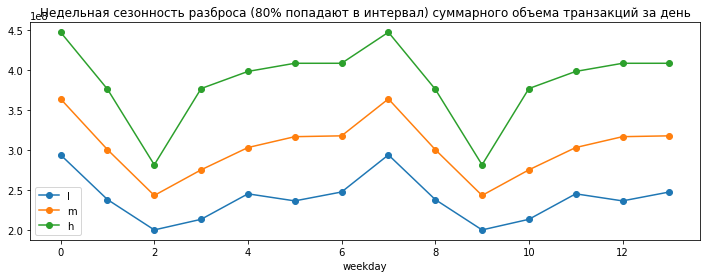

In [14]:
period = 7
ci = 80
_, ax = plt.subplots(1, 1, figsize=(12, 4))
pd.concat([
    df_amounts_by_day.reset_index().assign(weekday=lambda x: x['dt'] % period) \
        .groupby('weekday')['amount'].apply(
            lambda x: pd.Series(np.percentile(x, [50 - ci / 2, 50, 50 + ci / 2]), 
            index=['l', 'm', 'h']),
        ).unstack(),
    df_amounts_by_day.reset_index().assign(weekday=lambda x: x['dt'] % period + period) \
        .groupby('weekday')['amount'].apply(
            lambda x: pd.Series(np.percentile(x, [50 - ci / 2, 50, 50 + ci / 2]), 
            index=['l', 'm', 'h']),
        ).unstack(),
    ]) \
    .plot(ax=ax, marker='o')
ax.set_title(f'Недельная сезонность разброса ({ci}% попадают в интервал) суммарного объема транзакций за день')
plt.show()

## Смотрим насколько отличаются друг от друга суммы из разных дней

Насколько хорошо можно понять к какому дня относится сумма для каждой пары дней

In [15]:
def dist_sep(a, b):
    def _f(a, b):
        if a.mean() > b.mean():
            a, b = b, a
        df = pd.concat([
            pd.DataFrame({'v': a, 't0': 1, 't1': 0}),
            pd.DataFrame({'v': b, 't0': 0, 't1': 1}),
        ]).groupby('v').sum().sort_values('v')
        df['t0c'] = df['t0'].cumsum()
        df['t1c'] = df['t1'].sum() - df['t1'].cumsum()
        df['g'] = (df['t0c'] + df['t1c']) / (df['t0'].sum() + df['t1'].sum())

        return df['g'].max()
    
    return np.array([_f(_a, _b) for _a, _b in zip(a, b)])
        

In [16]:
dist_sep([np.array([0, 1, 1, 1, 1, 2, 2, 3])], [np.array([1, 2, 2, 3, 3, 3, 3])])

array([0.73333333])

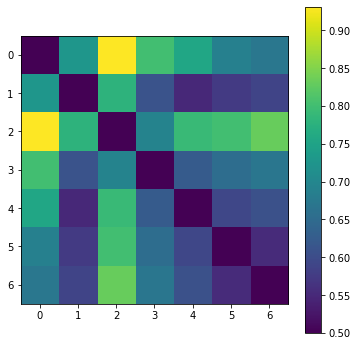

In [17]:
period = 7
df_grp = df_amounts_by_day.reset_index().assign(weekday=lambda x: x['dt'] % period) \
.groupby('weekday')['amount'].apply(np.array).reset_index().assign(k=1)
ms = pd.merge(df_grp, df_grp, on='k').drop(columns='k') \
.assign(sep=lambda x: dist_sep(x['amount_x'], x['amount_y'])) \
.pivot(index='weekday_x', columns='weekday_y', values='sep').values

plt.figure(figsize=(6, 6))
plt.imshow(ms)
plt.colorbar()
plt.show()

In [18]:
# top 10 the most different weekdays
np.stack([
    np.argsort(np.triu(ms), axis=None) // 7, 
    np.argsort(np.triu(ms), axis=None) % 7,
    ms[np.argsort(np.triu(ms), axis=None) // 7, np.argsort(np.triu(ms), axis=None) % 7],
]).T[::-1][:10]

array([[0.        , 2.        , 0.93129771],
       [2.        , 6.        , 0.83076923],
       [0.        , 3.        , 0.80152672],
       [2.        , 5.        , 0.8       ],
       [2.        , 4.        , 0.79230769],
       [1.        , 2.        , 0.77862595],
       [0.        , 4.        , 0.75572519],
       [0.        , 1.        , 0.72727273],
       [2.        , 3.        , 0.69230769],
       [0.        , 5.        , 0.6870229 ]])

# AR baseline

In [19]:
df_amounts_by_day

dt
0      3.160563e+08
1      2.165623e+08
2      2.333121e+08
3      2.937045e+08
4      2.393980e+08
           ...     
452    2.469914e+08
453    2.560016e+08
454    3.934018e+08
455    4.706483e+08
456    2.416400e+08
Name: amount, Length: 457, dtype: float64

In [20]:
hist_size = 28

In [21]:
X_ar = pd.DataFrame({f'col_{i:02d}': df_amounts_by_day.shift(i) for i in range(hist_size)})
y = df_amounts_by_day.shift(-1).iloc[hist_size - 1:-1]

In [22]:
y_ewm = df_amounts_by_day.ewm(alpha=0.1).mean().iloc[hist_size - 1:-1]

In [23]:
y.shape, y_ewm.shape

((429,), (429,))

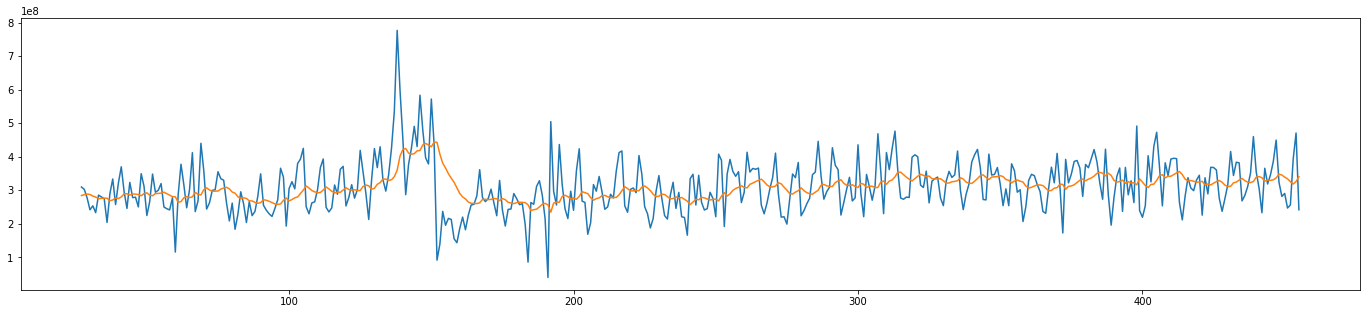

In [24]:
plt.figure(figsize=(24, 5))
plt.plot(y)
plt.plot(y_ewm)
plt.show()

In [25]:
def _split(t):
    return t.values[:-160], t.values[-160:-80], t.values[-80:]

y_train, y_valid, y_test = _split(y)
y_ewm_train, y_ewm_valid, y_ewm_test = _split(y_ewm)

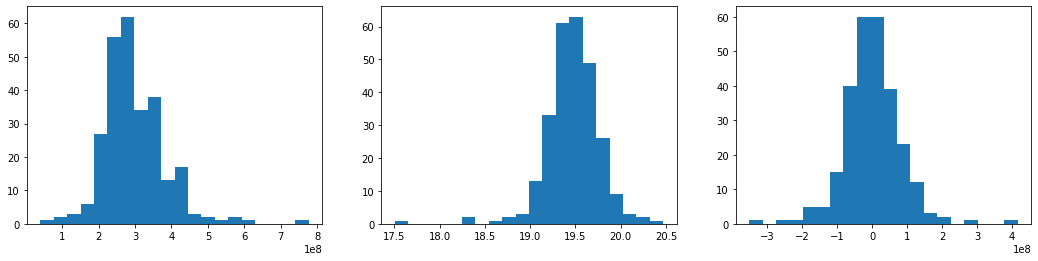

In [26]:
_, axs = plt.subplots(1, 3, figsize=(6 * 3, 4))
axs[0].hist(y_train, bins=20)
axs[1].hist(np.log1p(y_train), bins=20)
axs[2].hist(y_train - y_ewm_train, bins=20)
plt.show()

In [27]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score

In [28]:
y.shape, y_ewm.shape

((429,), (429,))

R2 train: 0.352
R2 valid: 0.248
R2 test:  0.216


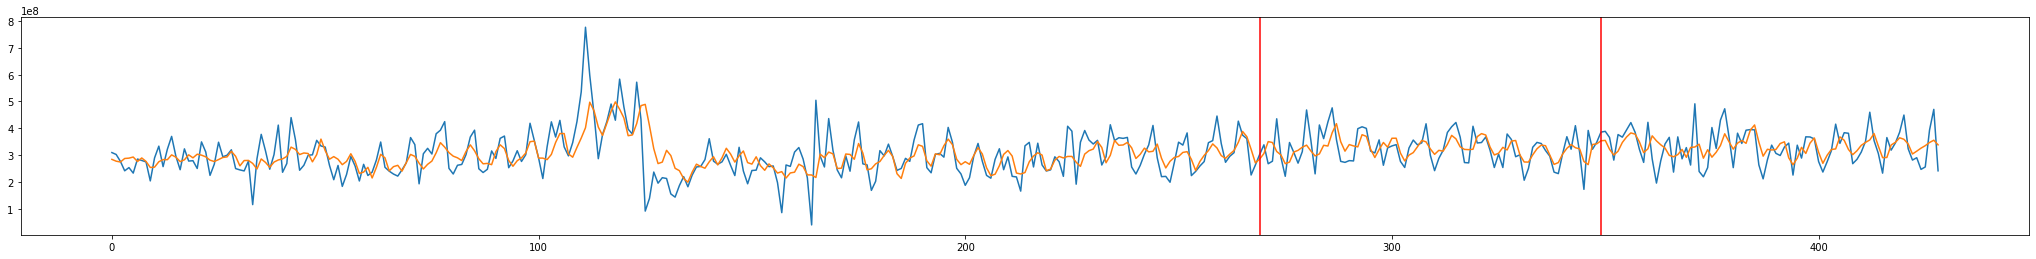

In [29]:
X = X_ar.reindex(y.index)

X_ewm_ar = X.ewm(alpha=0.1).mean()
X_ar_train, X_ar_valid, X_ar_test = _split(X)
X_ewm_ar_train, X_ewm_ar_valid, X_ewm_ar_test = _split(X_ewm_ar)

X_scale = (X_ar_train - X_ewm_ar_train).std(axis=0)
y_scale = (y_train - y_ewm_train).std()

train_ix = (-3 < (y_train - y_ewm_train) / y_scale) & ((y_train - y_ewm_train) / y_scale < 3)

# reg_model = Lasso(alpha=0.01, fit_intercept=False)
reg_model = Ridge(alpha=300.0, fit_intercept=False)
# reg_model = LinearRegression(fit_intercept=False)
# reg_model = MeanModel(14)
reg_model.fit(
    ((X_ar_train - X_ewm_ar_train) / X_scale)[train_ix],
    ((y_train - y_ewm_train) / y_scale)[train_ix],
)

predict_train = reg_model.predict((X_ar_train - X_ewm_ar_train) / X_scale) * y_scale + y_ewm_train
predict_valid = reg_model.predict((X_ar_valid - X_ewm_ar_valid) / X_scale) * y_scale + y_ewm_valid
predict_test = reg_model.predict((X_ar_test - X_ewm_ar_test) / X_scale) * y_scale + y_ewm_test

print('R2 train: {:.3f}'.format(r2_score(y_train, predict_train)))
print('R2 valid: {:.3f}'.format(r2_score(y_valid, predict_valid)))
print('R2 test:  {:.3f}'.format(r2_score(y_test, predict_test)))

plt.figure(figsize=(36, 4))
plt.plot(y.values)
plt.plot(np.concatenate([
    predict_train,
    predict_valid,
    predict_test,
]))
plt.axvline(len(y) - 80, color='red')
plt.axvline(len(y) - 160, color='red')
plt.show()

In [30]:
train_dt_end = np.sort(df_trx['dt'].unique())[:-160].max()
train_dt_end

296

In [31]:
used_mcc = df_trx[lambda x: x['dt'].lt(train_dt_end)]['mcc_code'].value_counts().iloc[:100].index
df_mcc_features = df_trx[lambda x: x['mcc_code'].isin(used_mcc)] \
    .pivot_table(index='dt', columns='mcc_code', values='amount', aggfunc='mean') \
    .reindex(columns=used_mcc).fillna(0)

In [32]:
df_mcc_features

,6011,6010,4814,5411,4829,5499,5541,5912,5331,5812,...,5949,6300,5422,5542,5462,5451,7993,5993,6211,8641
dt,,,,,,,,,,,,,,,,,,,,,
0,58246.906573,-101290.138469,4692.915121,13873.354686,206268.295108,7796.251222,22526.512960,13119.107136,11784.799213,15784.641675,...,17181.255000,55456.265000,15283.456667,15261.000,2201.000000,8669.230000,0.000,1504.760000,1.335199e+06,0.000000
1,50466.633478,-116395.042585,4644.564249,14475.465786,179906.629926,7877.288278,19520.913015,11236.234830,15176.732589,19859.140647,...,0.000000,15037.300000,8414.717500,15715.570,0.000000,6019.050000,16821.910,9838.235000,0.000000e+00,0.000000
2,60525.575428,-94185.525543,4447.165650,12242.825522,161869.507133,6771.880551,18207.370275,11870.606538,12100.743247,40854.540441,...,63475.195000,4242.760000,12824.180000,13340.740,0.000000,2683.640000,20190.780,39350.616667,0.000000e+00,2582.800000
3,66273.586184,-167663.935277,4789.852210,12777.869142,198927.734358,6332.654376,19008.444802,13026.399471,11810.130267,14084.327766,...,11653.610000,243279.096667,24570.320000,10140.310,16889.290000,25358.190000,0.000,2976.792500,0.000000e+00,0.000000
4,63450.678651,-171000.926293,5146.555435,11233.413075,210998.325932,7559.367776,22683.847692,10923.011394,9424.984520,13026.849318,...,1897.800000,338660.795000,8636.440000,0.000,26590.206000,741.150000,0.000,7624.885000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,47954.861354,-119349.377529,8658.016717,10074.900305,176822.223081,6377.725944,26870.201755,11799.399074,9323.282000,10590.882727,...,28455.752500,77229.902000,5601.766667,11102.685,9485.250000,0.000000,6715.290,2919.690000,4.480415e+04,5476.293889
453,43374.733367,-133671.947292,5214.958719,12718.202886,189537.315626,6841.338371,21122.332080,11344.605613,14280.367276,11684.616512,...,11723.683333,0.000000,8672.828000,0.000,5206.034000,18851.832857,14564.765,4393.572500,6.416906e+03,2836.592333
454,56293.561628,-137317.323333,4680.757225,11730.233147,240457.294538,6564.311364,27778.761662,11399.324734,14042.566732,12436.036667,...,1347.550000,58058.045000,5568.748000,14598.455,5374.734286,8683.983333,3346.415,11585.180000,1.367460e+04,3407.360455


In [33]:
used_types = df_trx[lambda x: x['dt'].lt(train_dt_end)]['tr_type'].value_counts().iloc[:50].index
df_type_features = df_trx[lambda x: x['tr_type'].isin(used_types)] \
    .pivot_table(index='dt', columns='tr_type', values='amount', aggfunc='mean') \
    .reindex(columns=used_types).fillna(0)

In [34]:
df_mcc_features.shape, df_type_features.shape

((457, 100), (457, 50))

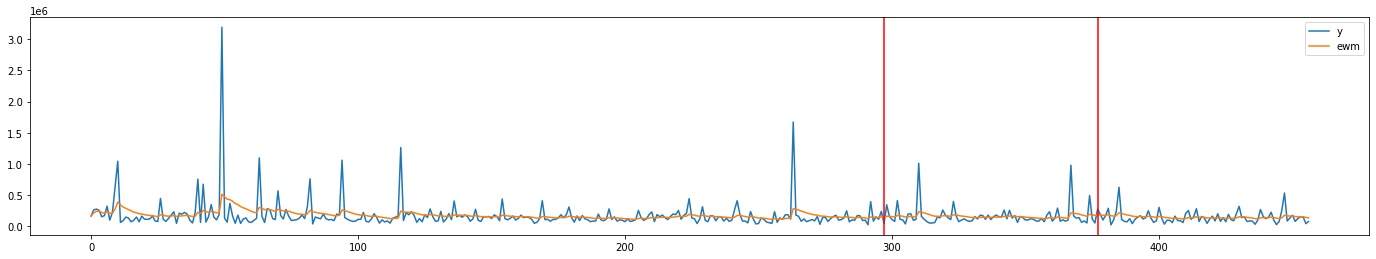

In [35]:
i = 50
plt.figure(figsize=(24, 4))
plt.plot(df_mcc_features.iloc[:, i], label='y')
plt.plot(df_mcc_features.ewm(alpha=0.1).mean().iloc[:, i], label='ewm')
plt.axvline(len(df_amounts_by_day) - 80, color='red')
plt.axvline(len(df_amounts_by_day) - 160, color='red')
plt.legend()
plt.show()

R2 train: 0.498
R2 valid: 0.368
R2 test:  0.190


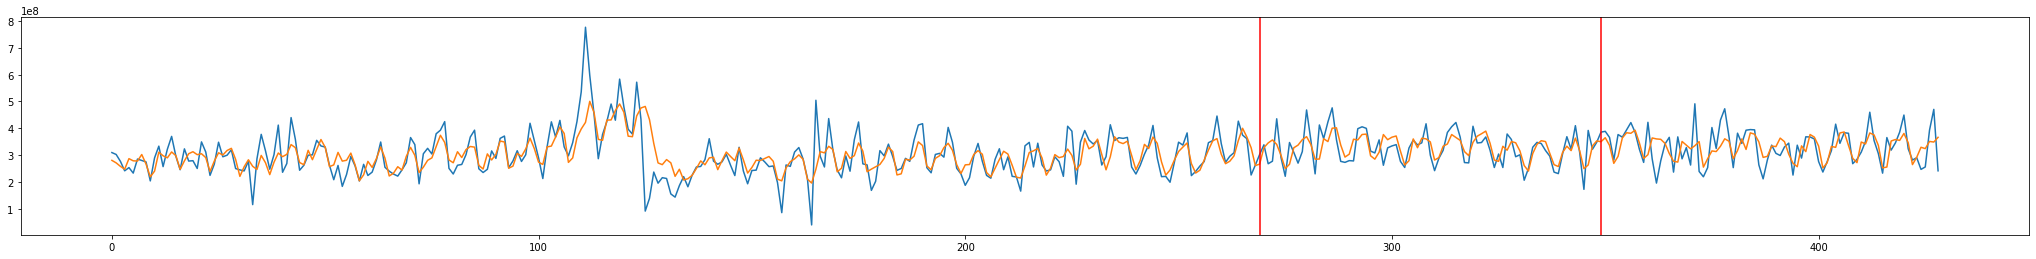

In [36]:
X = pd.concat([
    X_ar,
    *[df_mcc_features.shift(i).iloc[:, :50] for i in range(0, 28, 7)],
#     *[df_type_features.shift(i).iloc[:, :25] for i in range(0, 1, 1)]
], axis=1)

X_ewm_ar = X.ewm(alpha=0.1).mean()
X_ar_train, X_ar_valid, X_ar_test = _split(X.reindex(y.index))
X_ewm_ar_train, X_ewm_ar_valid, X_ewm_ar_test = _split(X_ewm_ar.reindex(y.index))

X_scale = (X_ar_train - X_ewm_ar_train).std(axis=0)
y_scale = (y_train - y_ewm_train).std()

X_crops = np.percentile((X_ar_train - X_ewm_ar_train) / X_scale, [5, 95], axis=0)

train_ix = (-3 < (y_train - y_ewm_train) / y_scale) & ((y_train - y_ewm_train) / y_scale < 3)

# reg_model = Lasso(alpha=0.1, fit_intercept=False)
reg_model = Ridge(alpha=300.0, fit_intercept=False)
# reg_model = LinearRegression(fit_intercept=False)
# reg_model = MeanModel(14)
reg_model.fit(
    np.clip(((X_ar_train - X_ewm_ar_train) / X_scale)[train_ix], *X_crops),
    ((y_train - y_ewm_train) / y_scale)[train_ix],
)

predict_train = reg_model.predict(
    np.clip((X_ar_train - X_ewm_ar_train) / X_scale, *X_crops)) * y_scale + y_ewm_train
predict_valid = reg_model.predict(
    np.clip((X_ar_valid - X_ewm_ar_valid) / X_scale, *X_crops)) * y_scale + y_ewm_valid
predict_test = reg_model.predict(
    np.clip((X_ar_test - X_ewm_ar_test) / X_scale, *X_crops)) * y_scale + y_ewm_test

print('R2 train: {:.3f}'.format(r2_score(y_train, predict_train)))
print('R2 valid: {:.3f}'.format(r2_score(y_valid, predict_valid)))
print('R2 test:  {:.3f}'.format(r2_score(y_test, predict_test)))

plt.figure(figsize=(36, 4))
plt.plot(y.values)
plt.plot(np.concatenate([
    predict_train,
    predict_valid,
    predict_test,
]))
plt.axvline(len(y) - 80, color='red')
plt.axvline(len(y) - 160, color='red')
plt.show()

In [37]:
# without details
R2 train: 0.352
R2 valid: 0.248
R2 test:  0.216


SyntaxError: invalid syntax (<ipython-input-37-4d19f6786217>, line 2)

In [38]:
reg_model.coef_

array([ 6.48666152e-02,  2.93825212e-02,  4.27713844e-02, -8.55568209e-03,
       -8.78653995e-03,  2.11489190e-02,  6.61581124e-02,  1.26496661e-02,
        5.43691760e-03,  1.98622326e-03, -5.08219101e-02, -4.23582385e-02,
        9.47057758e-03,  2.96874161e-02, -2.20193682e-04, -6.85926656e-03,
       -6.14147283e-03, -3.04298095e-02, -2.91481856e-02,  2.91564826e-03,
        3.89868865e-02,  7.94767364e-03, -1.06749403e-02,  2.57592758e-03,
        1.29206990e-02, -2.38455292e-02,  5.95640168e-03,  4.86604390e-02,
        6.51207178e-02, -2.26029088e-02,  3.22762222e-02,  6.90465497e-03,
        2.26264000e-02, -1.67029983e-02, -1.29351213e-03,  1.93839343e-02,
        5.15689262e-03, -3.98965736e-02, -4.33326956e-02,  2.35644442e-02,
        6.62692219e-03, -7.68253120e-03, -5.27777829e-03, -1.10151761e-02,
       -1.64298858e-02, -2.71128374e-02, -4.86269050e-03, -9.02443935e-03,
       -1.30359487e-02, -2.05467176e-02, -4.52031938e-02, -6.90518272e-03,
        2.84829903e-02, -

In [39]:
!pwd

/mnt2/kireev/pycharm-deploy/pytorch-lifestream/experiments/scenario_gender/notebooks


In [ ]:
# import pickle

# with open('../data/df_mcc_features.np', 'wb') as f:
#     pickle.dump(df_mcc_features.values, f)

In [75]:
import pickle

with open('../data/df_mcc_features_zc_05.np', 'rb') as f:
    z, c = pickle.load(f)

R2 train: 0.337
R2 valid: 0.256
R2 test:  0.214


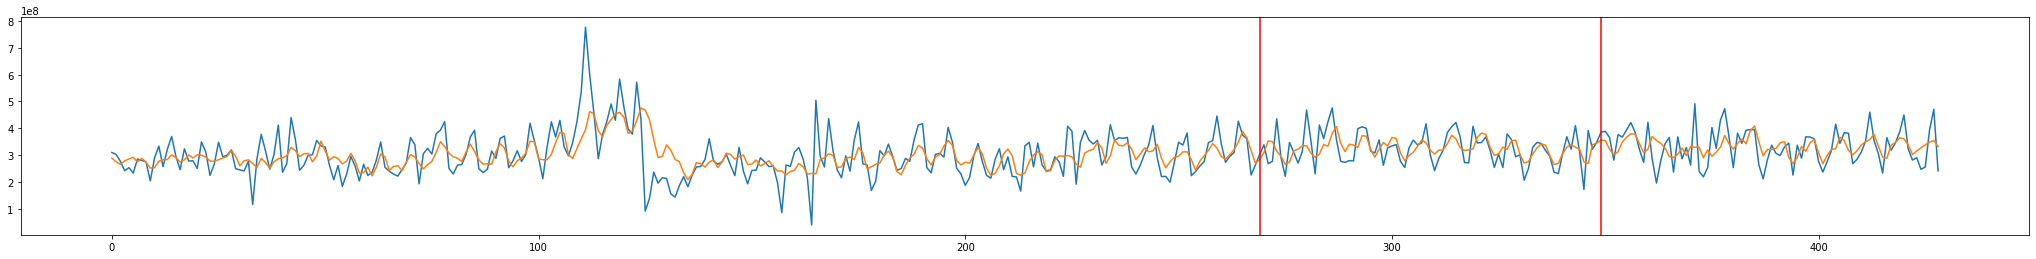

In [76]:
X = pd.concat([
    X_ar,
], axis=1)

X_ewm_ar = X.ewm(alpha=0.1).mean()
X_ar_train, X_ar_valid, X_ar_test = _split(X.reindex(y.index))
X_ewm_ar_train, X_ewm_ar_valid, X_ewm_ar_test = _split(X_ewm_ar.reindex(y.index))

X_scale = (X_ar_train - X_ewm_ar_train).std(axis=0)
y_scale = (y_train - y_ewm_train).std()

X_crops = np.percentile((X_ar_train - X_ewm_ar_train) / X_scale, [5, 95], axis=0)

train_ix = (-3 < (y_train - y_ewm_train) / y_scale) & ((y_train - y_ewm_train) / y_scale < 3)

# reg_model = Lasso(alpha=0.1, fit_intercept=False)
reg_model = Ridge(alpha=300.0, fit_intercept=False)
# reg_model = LinearRegression(fit_intercept=False)
# reg_model = MeanModel(14)
reg_model.fit(
    np.clip(((X_ar_train - X_ewm_ar_train) / X_scale)[train_ix], *X_crops),
    ((y_train - y_ewm_train) / y_scale)[train_ix],
)

predict_train = reg_model.predict(
    np.clip((X_ar_train - X_ewm_ar_train) / X_scale, *X_crops)) * y_scale + y_ewm_train
predict_valid = reg_model.predict(
    np.clip((X_ar_valid - X_ewm_ar_valid) / X_scale, *X_crops)) * y_scale + y_ewm_valid
predict_test = reg_model.predict(
    np.clip((X_ar_test - X_ewm_ar_test) / X_scale, *X_crops)) * y_scale + y_ewm_test

print('R2 train: {:.3f}'.format(r2_score(y_train, predict_train)))
print('R2 valid: {:.3f}'.format(r2_score(y_valid, predict_valid)))
print('R2 test:  {:.3f}'.format(r2_score(y_test, predict_test)))

plt.figure(figsize=(36, 4))
plt.plot(y.values)
plt.plot(np.concatenate([
    predict_train,
    predict_valid,
    predict_test,
]))
plt.axvline(len(y) - 80, color='red')
plt.axvline(len(y) - 160, color='red')
plt.show()

In [77]:
X_ar.shape, z.shape, c.shape

((457, 28), (1, 457, 10), (1, 457, 48))

R2 train: 0.404
R2 valid: 0.179
R2 test:  0.180


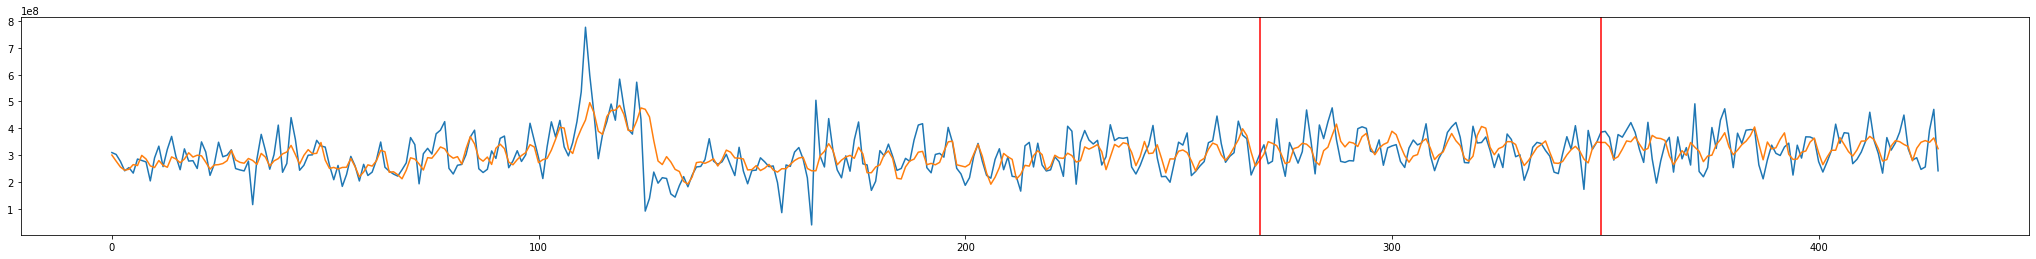

In [78]:
X = pd.concat([
    X_ar,
    pd.DataFrame(z[0], index=X_ar.index),
    pd.DataFrame(c[0], index=X_ar.index)
#     *[pd.DataFrame(z[0], index=X_ar.index).shift(i) for i in range(0, 28, 7)],
#     *[pd.DataFrame(c[0], index=X_ar.index).shift(i) for i in range(0, 28, 7)],
], axis=1)

X_ewm_ar = X.ewm(alpha=0.1).mean()
X_ar_train, X_ar_valid, X_ar_test = _split(X.reindex(y.index))
X_ewm_ar_train, X_ewm_ar_valid, X_ewm_ar_test = _split(X_ewm_ar.reindex(y.index))

X_scale = (X_ar_train - X_ewm_ar_train).std(axis=0)
y_scale = (y_train - y_ewm_train).std()

X_crops = np.percentile((X_ar_train - X_ewm_ar_train) / X_scale, [5, 95], axis=0)

train_ix = (-3 < (y_train - y_ewm_train) / y_scale) & ((y_train - y_ewm_train) / y_scale < 3)

# reg_model = Lasso(alpha=0.1, fit_intercept=False)
reg_model = Ridge(alpha=300.0, fit_intercept=False)
# reg_model = LinearRegression(fit_intercept=False)
# reg_model = MeanModel(14)
reg_model.fit(
    np.clip(((X_ar_train - X_ewm_ar_train) / X_scale)[train_ix], *X_crops),
    ((y_train - y_ewm_train) / y_scale)[train_ix],
)

predict_train = reg_model.predict(
    np.clip((X_ar_train - X_ewm_ar_train) / X_scale, *X_crops)) * y_scale + y_ewm_train
predict_valid = reg_model.predict(
    np.clip((X_ar_valid - X_ewm_ar_valid) / X_scale, *X_crops)) * y_scale + y_ewm_valid
predict_test = reg_model.predict(
    np.clip((X_ar_test - X_ewm_ar_test) / X_scale, *X_crops)) * y_scale + y_ewm_test

print('R2 train: {:.3f}'.format(r2_score(y_train, predict_train)))
print('R2 valid: {:.3f}'.format(r2_score(y_valid, predict_valid)))
print('R2 test:  {:.3f}'.format(r2_score(y_test, predict_test)))

plt.figure(figsize=(36, 4))
plt.plot(y.values)
plt.plot(np.concatenate([
    predict_train,
    predict_valid,
    predict_test,
]))
plt.axvline(len(y) - 80, color='red')
plt.axvline(len(y) - 160, color='red')
plt.show()

In [44]:
R2 train: 0.512
R2 valid: 0.369
R2 test:  0.279

SyntaxError: invalid syntax (<ipython-input-44-10e588929d04>, line 1)